In [1]:
import tensorflow as tf
import numpy as np
import mdn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from timeit import default_timer as timer
import xgboost as xgb

bin_count = 151

In [2]:
def find_first_zero(row):
    """ Given a row, starts at the end and looks for the first value that is above a threshold (1e-5)"""
    vals = list(row) 
  
    last_zero_index = -1
    for idx, val in enumerate(reversed(vals)): 
        if val > 1e-5:
            last_zero_index = bin_count - idx
            break
    return last_zero_index

In [3]:


def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins. Add a c """
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)
    #data_set['Output_Is_Not_End'] = ~data_set['Output_Is_End']
    
    

    data_set['Output_First_Zero'] = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]].apply(find_first_zero, axis=1)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End', 'Output_First_Zero', 'Output_genextremec_c', 'Output_genextreme_loc', 'Output_genextreme_scale'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End', 'Output_First_Zero', 'Output_genextremec_c', 'Output_genextreme_loc', 'Output_genextreme_scale']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

#filename = "/scratch/keh4nb/dust_training_data_all_bins_large.csv"
#filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins.csv"
filename = "/scratch/keh4nb/dust_training_data_all_bins_genextreme_full.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_146,Output_Bin_147,Output_Bin_148,Output_Bin_149,Output_Bin_150,Output_Is_End,Output_First_Zero,Output_genextremec_c,Output_genextreme_loc,Output_genextreme_scale
count,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,...,3.591900e+04,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,35919.000000,3.591900e+04
mean,0.000293,0.000278,0.000279,0.000332,0.000373,0.000413,0.000460,0.000518,0.000573,0.000631,...,1.001080e-03,0.002715,0.007736,0.024396,0.477105,0.499485,130.590495,0.954137,120.748412,5.833952e+00
std,0.000856,0.000780,0.000764,0.000902,0.000997,0.001090,0.001202,0.001333,0.001448,0.001568,...,4.768807e-03,0.006196,0.013168,0.039106,0.462729,0.500007,27.417063,0.912004,35.812616,7.409617e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-0.804153,41.664170,1.196273e-21
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,109.000000,0.736798,90.364093,3.995534e-02
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.678453e-18,0.000004,0.000009,0.000011,0.748803,0.000000,151.000000,1.020021,149.700467,4.045799e-01
75%,0.000097,0.000109,0.000121,0.000155,0.000181,0.000201,0.000223,0.000261,0.000302,0.000346,...,8.029774e-06,0.003671,0.012286,0.040380,0.941136,1.000000,151.000000,1.389495,149.969704,8.832335e+00
max,0.005742,0.004991,0.004757,0.005687,0.006199,0.006685,0.007276,0.007943,0.008431,0.008918,...,7.621570e-02,0.092835,0.126863,0.173059,1.000000,1.000000,151.000000,3.986359,150.000000,4.667685e+01


Test out what distributions could fit the output bins

In [ ]:
#!pip install statsmodels
from distfit import distfit
from tqdm import tqdm
#st.norm, st.expon, st.pareto, st.dweibull, st.t, st.genextreme, st.gamma, st.lognorm, st.beta
dist = distfit(distr=['norm', 'lognorm', 'gamma', 'laplace','dweibull', 'genlogistic', 'beta', 'genextreme', 'exponnorm'])
output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
# Scale our data to our bins
model_names = {}
print(len(y_train))
#Randomnly pick 5000 indexes
#johnsonb?
for idx, data in tqdm(y_train.loc[output_is_not_end_idx].drop(['Output_Is_End', 'Output_First_Zero'], axis=1).sample(2500, axis=0).iterrows()):
    t = np.floor(np.multiply(data.values,bin_count))
    new_samp = []
    for idx, e in enumerate(t):
        if e:
            # To generate our samples add the bin number e number of times
            new_samp.extend([idx for _  in range(int(e))])
    # Fit the distribution to our data
    if len(new_samp) == 0:
        print('no samps')
        continue
    else:
        dist.fit_transform(np.array(new_samp), verbose=1)
        best_model = dist.model['name']
        #print(dist.model['params'])
        try:
            model_names[best_model] += 1
        except KeyError:
            model_names[best_model] = 1
print(model_names)

Try xgboost for predicting whether all the particles are at the end of the distribution. Ended up getting over 99% test accuracy.

In [ ]:
#%pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42)
xgb_model.fit(X_train, y_train['Output_Is_End'],
             eval_set=[(X_train, y_train['Output_Is_End']), (X_test, y_test['Output_Is_End'])],
             eval_metric='error',verbose=True)

evals_result = xgb_model.evals_result()

In [4]:
preds = xgb_model.predict(X_test)

# Count the number of matches between predictions and labels
correct = np.sum(preds == y_test['Output_Is_End'])

# Calculate accuracy
accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy}")

#xgb_model.save_model('xgb_model_is_end.model')

Accuracy: 0.99867637326274


Train a linear regression model for predicting when first zero occurs on models where the dust is not all stacked at the end.

In [11]:

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",
                             eta=0.1,
                             n_estimators=100,
                             sub_sample=0.8,
                             colsample_bytree=0.8,
                             max_depth=8,
                              random_state=42)


# Only train on output not at end
output_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]
X_first_zero = X_train.loc[output_not_end_idx]
y_first_zero = y_train.loc[output_not_end_idx, 'Output_First_Zero']

xgb_model.fit(X_first_zero, y_first_zero,
             eval_set=[(X_first_zero, y_first_zero)],
             eval_metric='rmse', early_stopping_rounds=10, verbose=True)

evals_result = xgb_model.evals_result()

[12:35:10] WARNING: ../src/learner.cc:516: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:101.52958
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:91.49923
[2]	validation_0-rmse:82.42421
[3]	validation_0-rmse:74.25105
[4]	validation_0-rmse:66.90297
[5]	validation_0-rmse:60.32177
[6]	validation_0-rmse:54.36878
[7]	validation_0-rmse:49.01428
[8]	validation_0-rmse:44.21986
[9]	validation_0-rmse:39.87517
[10]	validation_0-rmse:36.01613
[11]	validation_0-rmse:32.55453
[12]	validation_0-rmse:29.39978
[13]	validation_0-rmse:26.55298
[14]	validation_0-rmse:23.98707
[15]	validation_0-rmse:21.68573
[16]	validation_0-rmse:19.66999
[17]	validation_0-rmse:17.81642
[18]	validation_0-rmse:16.13735
[19]	v

Best train result is 1.116 RMSE. Best test RMSE is 1.3

Preduct which bin the first zero will be in

In [12]:
from sklearn.metrics import mean_squared_error as MSE 

#Optionally load pretrained model
# Load first zero model
#xgb_model = xgb.XGBRegressor()
#xgb_model.load_model('xgb_model_first_zero.model')

# Only predict on output not at end
output_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]
X_test_first_zero = X_test.loc[output_not_end_test_idx]
y_test_first_zero = y_test.loc[output_not_end_test_idx, 'Output_First_Zero']

# Predict the model. Round preds since bins are whole numbers
pred_first_zero = np.rint(xgb_model.predict(X_test_first_zero)) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y_test_first_zero, pred_first_zero)) 
print(f"RMSE : {rmse}") 

pd.set_option('display.max_rows', None)
# Spot check the predictions and results
print(pd.DataFrame({"preds":pred_first_zero, "test":y_test_first_zero}).head(25))

RMSE : 2.161902764263808
        preds  test
111188  124.0   124
103839  125.0   125
134716  151.0   151
353969  123.0   123
275428  103.0   103
301768   83.0    81
16369   120.0    98
319834   67.0    67
313081   76.0    72
281799  102.0    98
205923   72.0    73
306664  129.0   128
77382   101.0   100
148301  119.0   119
154841  148.0   148
164320   90.0    90
238545  107.0   107
127682  122.0   122
255554  105.0   105
255962   78.0    78
242166  108.0   107
95012    99.0    98
340042   95.0    95
283604   75.0    75
182928  144.0   144


In [33]:
xgb_model.save_model('xgb_model_first_zero.model')

Train two MDNs, one on the dust at end and one without

In [7]:
def build_mdn_model(activation='sigmoid', k=16):
    """ k is the number of mixture models"""
    # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    # Network
    input = tf.keras.Input(shape=(l,))

    layer = tf.keras.layers.Dense(512, activation=activation, name='baselayer')(input)
    layer_2 = tf.keras.layers.Dense(128, activation=activation, name='layer_2')(layer)
    layer_3 = tf.keras.layers.Dense(64, activation=activation, name='layer_3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(32, activation=activation, name='layer_4')(layer_3)

    # Connect the mdn layer to the output of our neural network
    mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_3)
    model = tf.keras.models.Model(input, [mdn_layer])


    opt = tf.keras.optimizers.Adam()
    model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=opt)
    model.summary()
    return model

Build a mdn model for the outputs where the dust is at the end of the distribution (spike model)

In [ ]:
model_spike = build_mdn_model(k=32)
output_is_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X = X_train.loc[output_is_end_idx]
y = y_train.loc[output_is_end_idx].drop(['Output_Is_End', 'Output_First_Zero', 'Output_Genextreme_a', 'Output_Genextreme_b','Output_Genextreme_c'], axis=1)
spike_fit = model_spike.fit(x=X, y=y, batch_size=512, epochs=50, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

In [36]:
model_spike.save("spiked_mdn_model/model")

INFO:tensorflow:Assets written to: spiked_mdn_model/model/assets


In [14]:
from scipy.stats import entropy
def predict_for_test(model, X_test, y_test, k):
    """Samples the mixture density results and returns predictions"""
    start = timer()

    # Returns the predictions of the parameters of the distributions and weights
    preds = model.predict(X_test)
    samples_list = []
    # Obtain 5 samples per prediction
    for i in range(5):
        samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, bin_count, k, temp=1.0, sigma_temp=1.0))

    # Average the samples for our predicitons
    y_samples = np.mean(np.array(samples_list),axis=0)
    y_samples = y_samples.reshape(len(X_test),bin_count)
    # Convert negatives to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    end = timer()
    
    print(f"Total time taken: {end-start}. Seconds per prediction: {(end-start)/len(preds)}")
    
    return y_samples

Make predictions for the MDN where theres a spike at the end and evaluate the results

In [4]:
output_is_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_spike = X_test.loc[output_is_end_idx]
y_test_spike = y_test.loc[output_is_end_idx].drop(['Output_Is_End','Output_First_Zero'], axis=1)

model_spike = tf.keras.models.load_model('spiked_mdn_model/model', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, 32)})


spike_preds = predict_for_test(model_spike, X_test_spike, y_test_spike, 32)

Total time taken: 253.24760373681784. Seconds per prediction: 0.012881363364029392


In [15]:
from scipy.stats import entropy
def evaluate_fit(y_samples, y_test):
    ent = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_samples += c
    y_test += c
    
    for i in range(len(y_test)):
        e = entropy(y_samples[i], y_test.iloc[i])
        ent.append(e if e != np.inf else 1000)
    display(pd.DataFrame(ent).describe())
    return ent

The average entropy is 7 which is decent.

In [6]:
evaluate_fit(spike_preds, y_test_spike)

,0
count,19660.000000
mean,7.834118
std,15.420871
min,0.031026
25%,0.917441
50%,2.879487
75%,4.790842
max,116.308030


The graphs look really similar

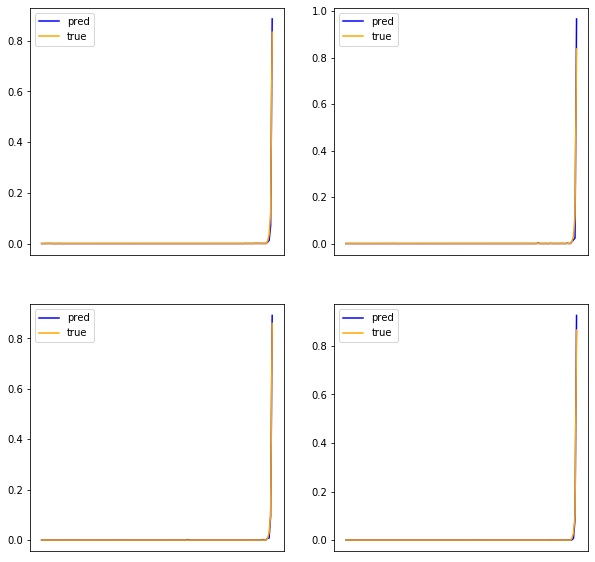

In [9]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_spike), size=1)[0]
    test_pred = spike_preds[i]
    true = y_test_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    
plt.show()

Create a seperate mdn model to use on the rest.

Create a MDN model to predict the 3 estimated parameters of the output distribution (gen extreme).

In [4]:
# Number of columns (bin count plus 8 inputs)
l = bin_count + 8
k = 24
output = 3
# Network
input = tf.keras.Input(shape=(l,))

layer = tf.keras.layers.Dense(256, activation='sigmoid', name='baselayer')(input)
l#ayer_2 = tf.keras.layers.Dense(128, activation='sigmoid', name='layer_2')(layer)
#layer_3 = tf.keras.layers.Dense(32, activation='sigmoid', name='layer_3')(layer_2)
#layer_4 = tf.keras.layers.Dense(32, activation='sigmoid', name='layer_4')(layer_3)

# Connect the mdn layer to the output of our neural network
# Only 3 parameters to predict
mdn_layer = mdn.MDN(output,k, name='mdn')(layer)
model_non_spike = tf.keras.models.Model(input, [mdn_layer])


opt = tf.keras.optimizers.Adam()
model_non_spike.compile(loss=mdn.get_mixture_loss_func(output,k), optimizer=opt)
model_non_spike.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 159)]             0         
_________________________________________________________________
baselayer (Dense)            (None, 256)               40960     
_________________________________________________________________
mdn (MDN)                    (None, 168)               43176     
Total params: 84,136
Trainable params: 84,136
Non-trainable params: 0
_________________________________________________________________


In [5]:
#model_non_spike = build_mdn_model()

output_is_not_end_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_idx]
y = y_train.loc[output_is_not_end_idx][['Output_genextremec_c', 'Output_genextreme_loc', 'Output_genextreme_scale']]
non_spike_fit = model_non_spike.fit(x=X, y=y, batch_size=64, epochs=25, validation_split=0.1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

Epoch 1/25
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
2261/2261 [==============================] - 9s 4ms/step - loss: 22.6447 - val_loss: 9.6898
Epoch 2/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.3175 - val_loss: 9.2031
Epoch 3/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1767 - val_loss: 9.1608
Epoch 4/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1414 - val_loss: 9.1811
Epoch 5/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1589 - val_loss: 9.1425
Epoch 6/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1425 - val_loss: 9.1149
Epoch 7/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1363 - val_loss: 9.1904
Epoch 8/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1378 - val_loss: 9.1174
Epoch 9/25
2261/2261 [==============================] - 8s 3ms/step - loss: 9.1528 - val_loss: 9

In [6]:
output_is_not_end_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non_spike = X_test.loc[output_is_not_end_idx]
#y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero', 'Output_Genextreme_a', 'Output_Genextreme_b','Output_Genextreme_c'], axis=1)
y_test_non_spike = y_test.loc[output_is_not_end_idx].drop(['Output_Is_End','Output_First_Zero', 'Output_genextremec_c', 'Output_genextreme_loc', 'Output_genextreme_scale'], axis=1)
# Returns the predictions of the parameters of the distributions and weights
preds = model_non_spike.predict(X_test_non_spike)
samples_list = []
# Obtain 5 samples per prediction
for i in range(10):
    samples_list.append(np.apply_along_axis(mdn.sample_from_output, 1, preds, 3, k, temp=1.0, sigma_temp=1.0))

# Average the samples for our predicitons
y_samples = np.mean(np.array(samples_list),axis=0)
y_samples = y_samples.reshape(len(X_test_non_spike),3)


Generate the predicted distribution by extracting the sample paramters and plug it into the pdf. Normalize the result

In [22]:
from scipy.stats import genextreme
non_spike_preds = []
bins = np.linspace(0, 150, 151)
for idx,sample in enumerate(y_samples):
    a,b,c = sample
    p = genextreme.pdf(bins, a, b, c)
    # Normalize pred
    p = p / np.sum(p)
    first_zero = int(pred_first_zero[idx])
    for j in range(first_zero, 151):
        p[j] = 0
    non_spike_preds.append(p)

When we dont use the information from the first zero prediction, the average entropy is 44. When we do, the average entropy is 2.4

In [23]:
ent = evaluate_fit(non_spike_preds, y_test_non_spike)

,0
count,17978.000000
mean,2.383119
std,2.417339
min,0.020807
25%,1.105878
50%,1.746577
75%,2.738652
max,92.327271


(array([1.05951955e-01, 1.72777097e-03, 1.13984890e-04, 1.79976143e-05,
        2.39968190e-05, 5.99920476e-06, 5.99920476e-06, 0.00000000e+00,
        0.00000000e+00, 5.99920476e-06]),
 array([2.08072644e-02, 9.29262613e+00, 1.85644450e+01, 2.78362639e+01,
        3.71080827e+01, 4.63799016e+01, 5.56517204e+01, 6.49235393e+01,
        7.41953582e+01, 8.34671770e+01, 9.27389959e+01]),
 <a list of 10 Patch objects>)

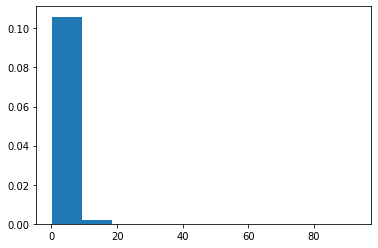

In [17]:
plt.hist(ent, bins=10, density=True)

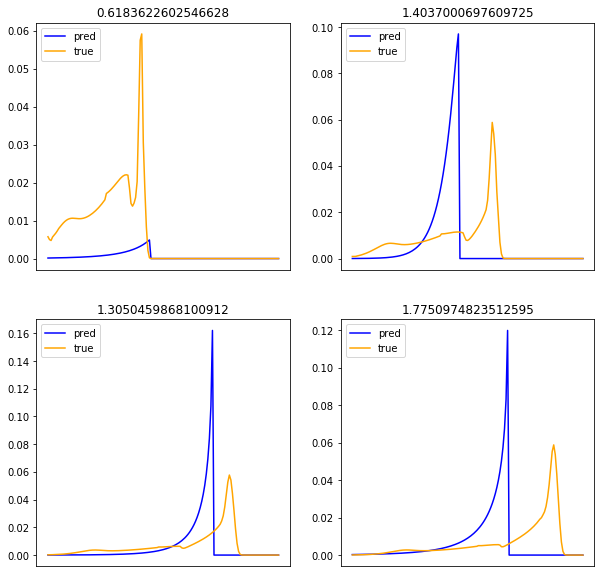

In [33]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_non_spike), size=1)[0]
    test_pred = non_spike_preds[i]
    true = y_test_non_spike.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    e = entropy(test_pred, true)
    ax.set_title(e)
    
plt.show()

Try to find the best tuning parameters for the neural network. The network gets stuck predicting everything as 0 (75% accuracy), but cannot improve on it.

In [ ]:
#%pip install -U keras-tuner
import kerastuner as kt

def build_model(hp):
        # Number of columns (bin count plus 8 inputs)
    l = bin_count + 8

    activation = 'selu'

    # Network
    input = tf.keras.Input(shape=(l,))

    layer =  tf.keras.layers.Dense(hp.Int('hidden_size', 16, 256, step=16, default=128), activation=hp.Choice('activation', values=['relu', 'selu', 'tanh', 'swish'], default='relu'), name='baselayer')(input)
    #layer = tf.keras.layers.Dense(1024, activation='relu', name='baselayer')(input)
    #layer_2 = tf.keras.layers.Dense(1024, activation='tanh', name='baselayer2')(layer)
    #layer_3 = tf.keras.layers.Dense(16, activation='tanh', name='baselayer3')(layer_2)
    #layer_4 = tf.keras.layers.Dense(64, activation=activation, name='baselayer4')(layer_3)
    #layer_5 = tf.keras.layers.Dense(32, activation=activation, name='baselayer5')(layer_4)
    # Connect the mdn layer to the output of our neural network
    #mdn_layer = mdn.MDN(bin_count,k, name='mdn')(layer_5)
    #model = tf.keras.models.Model(input, [mdn_layer])

    # 2 classes
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="predictions")(layer)
    model = tf.keras.models.Model(input, [outputs])


    #opt = tf.keras.optimizers.Adam(learning_rate=1e4)
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log'))
    #model.compile(loss=mdn.get_mixture_loss_func(bin_count,k), optimizer=tf.keras.optimizers.Adam())
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.tuners.BayesianOptimization(
  build_model,
  objective='val_accuracy',
  max_trials=50)

tuner.search(x=X_train, y=y_train, batch_size=128, epochs=30, validation_split=0.1, class_weight=cweights, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [5]:
preds = model.predict(X_test)
display(pd.DataFrame(preds).describe())
display(y_test.describe())

,0
count,40017.000000
mean,0.502865
std,0.064357
min,0.042015
25%,0.452332
50%,0.509930
75%,0.547307
max,0.598693


,Output_Is_End
count,40017.000000
mean,0.243771
std,0.429362
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [93]:
tuner.results_summary()

In [95]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2394/2394 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.78 - ETA: 1s - loss: 0.6925 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6921 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 1s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accuracy: 0.75 - ETA: 0s - loss: 0.6920 - accuracy: 0.75 - ETA: 0s - loss: 0.6919 - accura

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1251/1251 [==============================] - 1s 513us/step - loss: 0.6914 - accuracy: 0.5298
Test accuracy: 0.5297748446464539
